# Transportation Operations - Flight Delay Prediction

# Introduction - the problem context

The data and the scenario in this practical is from a real case and data from commercial airlines, specifically American Airlines (AA). Scheduled flights On Time Performance (OTP) is currently just over 80% which is acceptable and rather good but with significant room for improvement. Mny delays are caused by factors out of the control of commercial airlines. Delays incur costs and the aim is both to reduce delays, but also to anticipate / predict them, so as to enable appropriate planning. You are provided a dataset frm the US Dept of Transportation with all domestic flights of the airline for a whole calendar year. 

Predicting delays can be treated as both a classification (delay longer than a threshold classified as delay) and regression problem (delay time). 

You will need Python libraries pandas, numpy to work with the data, sklearn (scikit-learn), and statmodels .... to work with machine learning and performance assessment, and matplotlib and seaborn for visualisations. If non already installed, you can install any of them through
pip install "library" (where "library" is the name of the library)
or 
pip install --upgrade "library"
The libraries are already installed on Google Colab, apart from skope rules, which can be installed via: 
!pip install --upgrade rulefit interpret skope-rules

## The Preparations

### Loading the Libraries

In [10]:
import math

In [11]:
import pandas as pd
import numpy as np

In [12]:
import sys

In [13]:
import six

In [14]:
from sklearn.model_selection import train_test_split

In [56]:
from sklearn import metrics, linear_model, tree, neighbors, ensemble, naive_bayes

In [16]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [17]:
from sklearn.pipeline import make_pipeline

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import statsmodels.api as sm

In [21]:
sys.modules['sklearn.externals.six'] = six
#this is mostly for compatibility

### Understanding and Preparing the Data

In [23]:
aad18_df = pd.read_csv('aa-domestic-delays-2018.csv')

You have to wait. This is a large file of nearly 1m records. Check the file attributes and size. There are 23 columns. 

In [24]:
aad18_df.info

<bound method DataFrame.info of         FL_NUM ORIGIN DEST PLANNED_DEP_DATETIME  CRS_DEP_TIME  DEP_TIME  \
0          419    DCA  DFW  2018-01-01 11:55:00          1155    1149.0   
1          419    DFW  DCA  2018-01-01 07:05:00           705     700.0   
2          420    DEN  PHL  2018-01-01 11:48:00          1148    1145.0   
3          420    PHL  DEN  2018-01-01 08:25:00           825     824.0   
4          421    DCA  CLT  2018-01-01 11:55:00          1155    1147.0   
...        ...    ...  ...                  ...           ...       ...   
899522    1815    DCA  CLT  2018-12-31 15:34:00          1534    1530.0   
899523    1816    CLT  DFW  2018-12-31 17:51:00          1751    1757.0   
899524    1817    CLT  MEM  2018-12-31 20:15:00          2015    2010.0   
899525    1818    CLT  RDU  2018-12-31 13:00:00          1300    1323.0   
899526    1818    RDU  CLT  2018-12-31 14:35:00          1435    1443.0   

        DEP_DELAY   DEP_AFPH  DEP_RFPH  TAXI_OUT  ...  DISTANCE  CR

Check if there are any 'not a number'(NAN) entries - actually there aren't any. 

In [28]:
aad18_df.isnull().sum()

FL_NUM                  0
ORIGIN                  0
DEST                    0
PLANNED_DEP_DATETIME    0
CRS_DEP_TIME            0
DEP_TIME                0
DEP_DELAY               0
DEP_AFPH                0
DEP_RFPH                0
TAXI_OUT                0
WHEELS_OFF              0
CRS_ELAPSED_TIME        0
PCT_ELAPSED_TIME        0
DISTANCE                0
CRS_ARR_TIME            0
ARR_AFPH                0
ARR_RFPH                0
ARR_DELAY               0
CARRIER_DELAY           0
WEATHER_DELAY           0
NAS_DELAY               0
SECURITY_DELAY          0
LATE_AIRCRAFT_DELAY     0
dtype: int64

Here is the interpretation of the data attributes. 

Flight Definition attributes
FL_NUM: Flight number
ORIGIN: Starting airport code (IATA)
DEST: Destination airport code (IATA)

Flight Departure attributes
PLANNED_DEP_DATETIME: The planned date and time of the flight.
CRS_DEP_TIME: The planned departure time.
DEP_TIME: The actual departure time.
DEP_AFPH: The number of actual flights per hour occurring during the interval in between the planned and actual departure from the origin airport (factoring in 30 minutes of padding). The feature tells you how busy the origin airport was during takeoff.
DEP_RFPH: The departure relative flights per hour is the ratio of actual flights per hour over the median amount of flights per hour that occur at the origin airport at that time of day, day of the week, and month of the year. The feature tells you how relatively busy the origin airport was during takeoff.
TAXI_OUT: The time duration elapsed between the departure from the origin airport gate and wheels off.
WHEELS_OFF: point in time that the aircraft's wheels leave the ground.

In-flight attributes
CRS_ELAPSED_TIME: The planned amount of time needed for the flight trip.
PCT_ELAPSED_TIME: The ratio of actual flight time over planned flight time to gauge the plane's relative speed.
DISTANCE: The distance between two airports.

Arrival attributes
CRS_ARR_TIME: The planned arrival time.
ARR_AFPH: The number of actual flights per hour occurring during the interval between the planned and actual arrival time at the destination airport (factoring in 30 minutes of padding). The feature tells you how busy the destination airport was during landing.
ARR_RFPH: The arrival relative flights per hour is the ratio of actual flights per hour over the median amount of flights per hour that occur at the destination airport at that time of day, day of the week, and month of the year. The feature tells you how relatively busy the destination airport was during landing.

Delay attributes
DEP_DELAY: The total delay on departure in minutes.
ARR_DELAY: The total delay on arrival in minutes; this can be subdivided into any of the following attributes: a) CARRIER_DELAY: The delay in minutes caused by circumstances within the airline's control (for example, maintenance or crew problems, aircraft cleaning, baggage loading, fueling, and so on).b) WEATHER_DELAY: The delay in minutes caused by significant meteorological conditions (actual or forecasted).c) NAS_DELAY: The delay in minutes mandated by a national aviation system such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.d) SECURITY_DELAY: The delay in minutes caused by the evacuation of a terminal or concourse, re-boarding of an aircraft because of a security breach, faulty screening equipment, or long lines above 29 minutes in screening areas.e) LATE_AIRCRAFT_DELAY: The delay in minutes caused by a previous flight with the same aircraft that arrived late.

#### Data Preparation

First we convert datetime attributes ti datatime format 

In [14]:
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])

Month and day of the week could be of interest for prediction (possible seasonality) but perhaps the exact day and time might not matter. We are adding new attributes created from the original ones, to store them. 

In [15]:
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek

And we don't need the PLANNED_DEP_DATETIME any more, so we drop it. 

In [29]:
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

Of interest for a prediction task is whether an airport (arrival or destination) is a hub or not. You will take into account that Charlotte, Chicago–O'Hare, Dallas/Fort Worth, Los Angeles, Miami, New York–JFK, New York–LaGuardia, Philadelphia, Phoenix–Sky Harbor, and Washington–National are hubs. Therefore, these are encoded with their IATA codes, dropping other columns which won't be relevant for the prediction. 

In [30]:
#Create list with 10 hubs
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']
#Boolean series for if ORIGIN or DEST are hubs
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)
#Use boolean series to set ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1
#Delete columns with codes
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

Now we have more useful attributes to base our prediction (say the X attributes), but we have not created yet the predicted attribute (say the Y attribute). 
We have the following possibilities. There is ARR_DELAY, indicating the total delay in minutes, irrespective of the delay reason; we all have the CARRIER_DELAY indicating the specific delay attributed to the airline. Take a look at a few records f fligts which had a delay longer than 15 minutes (i.e. the formal definition of a delay). 

In [31]:
aad18_df.loc[aad18_df['ARR_DELAY'] > 15, ['ARR_DELAY','CARRIER_DELAY']].head(10)

,ARR_DELAY,CARRIER_DELAY
8,168.0,136.0
16,20.0,5.0
18,242.0,242.0
19,62.0,62.0
22,19.0,19.0
26,26.0,0.0
29,77.0,77.0
32,19.0,19.0
33,18.0,1.0
40,36.0,16.0


For our analysis, although it is useful to know the total delay, the airline is interested in delays which are attributable to the ariline. So we will drop the ARR_DELAY ttribute. 

In [32]:
aad18_df = aad18_df.drop(['ARR_DELAY'], axis=1)

Now we are ready to prepare our dataset in a X, Y form for machine learning. We will split the dataset into subsets for training and testing. For regression tasks, Y will be a number, the CARRIER_DELAY. But for classification, we need to convert it to a binary outcome, depending on whether it is longer than 15 minutes or not. 
Note that every time we create random dataset splits, different splits will be produces, resulting also to different results. We choose a fixed random_state seed if we want to have reproducibility of results, or a employ a random one if not. 

In [33]:
rand = 9
y = aad18_df['CARRIER_DELAY']
X = aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

Our first analysis is to check for linerar corellation of each attribute with the CARRIER_DELAY

In [34]:
corr = aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
ORIGIN_HUB             0.015334
DEST_HUB               0.013932
DISTANCE               0.010680
CRS_ELAPSED_TIME       0.008801
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
SECURITY_DELAY         0.000460
Name: CARRIER_DELAY, dtype: float64

Naturally, the DEP_DELAY, as expected, is largely responsible for an arrival delay. But other attributes aren't strongly individually corellated. However, this does not mean that they may not have a joint influence, or that they may not have a nonlinear impact on delays. 

## Model Interpretation Approaches

### Delay Prediction as a Regression Problem

#### Training and Evaluating the Regression Models

We will use the same dataset splits for a range of methods and will iterate for each method. The methods are defined next through a 'dictionary'. The dictionary is also used to create an identical data structure for each methods, to store and compare performance results. 

In [84]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()}, 
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
        #Trees  
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, n_estimators=20, random_state=rand)}, 
    }

In [85]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()},
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
    
        #Trees  
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, n_estimators=50, random_state=rand)}, 
    }    

linear: This is the linear regression. Simple to use but not expected to perform well when more complex and non linear relations between attributes exist. 

linear_poly: This is the polynomial regression, here set to a degree of 2 (quadratic) to keep it somewhat less complex. This is much more complext than the linear one: it takes as inputs, apart from the original attributes, their squared value, and their pair-wise multiplicative interactions (products). 

ridge: This is the Ridge regression of the linear regression, trained by Ordinary Least Squares. The risk here is fitting the data too much (overfitting). So ridge can use regularisation (L1 or L2 norm) to penalise complexity and control overfit. The employed process does automatic cross-validated regularisation through the defines alpha parameters. 

decision_tree: Very interpretable but also 'brittle' type of model that may easily overfit the data. Setting a maximum tree depth prevents the tree for growing too much and therefore reduces overfit. 

random_forest: This is the Ensemble version of the Tree method. You can set the number of trees and the depth of the three. For a good performance you need a large number of trees. But here we keep this to a low number to reduce computation time. 

And now we will iterate the training of the models. Some methods are more computatinally expensive (polynomial, knn, random forest). We use very conservative complexity settings to allow them to execute in reasonable time. But we could choose to exclude any of these methods (try excluding knn that takes long to exectute, as it has to indentify nearest neighbours within a large dataset (even if it searches for a single neighbour). Or you may simply run a single method. 

In [86]:
for model_name in reg_models.keys():
    print(model_name)
    fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    print("Now will calculate performance metrics")
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

linear
Now will calculate performance metrics
linear_poly
Now will calculate performance metrics
ridge
Now will calculate performance metrics
knn
Now will calculate performance metrics
decision_tree
Now will calculate performance metrics
random_forest
Now will calculate performance metrics


In [90]:
print("Now will show performance metrics")
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['R2_test'])

Now will show performance metrics


,RMSE_train,RMSE_test,R2_test
random_forest,5.163038,6.110493,0.955744
linear_poly,6.228354,6.350692,0.952196
linear,7.820889,7.884429,0.926318
decision_tree,6.542924,8.020552,0.923751
knn,7.360379,9.260888,0.898345
ridge,46.832485,46.878625,-1.604794


If you were patient enough to allo knn with 1 nearest neighbour to train, you will see a 0 RMSE_train error: this is natural as it employs one of the original data as the nearest neighbour, so it's a perfect match. But at the same time it's a very poor choice for overfiting and so the RMSE_test error is higher. If you were even more patient and had a knn with a higher number of neighbours, such as 7, you would get better results/generalisation. Choosing appropriate settings for the random forest is likely to produce better results in this case. 

### Delay Prediction as a Classification Problem

#### Training and Evaluating the Classification Models

We follow a similar "ditionary approach" as in the regression case. We will ridge classification, decision tree, and random forest. Random forest will be the most computatonally expensive one, so be prepared to wait a bit if you choose larger trees and number of estimators. Some of these methods can involve 'balancing' for the different classes of the classification problem, useful when dealing with imbalanced data sets (i.e. having many more data from one class, compared to another). 

In [91]:
class_models = {
        #Generalized Linear Models (GLMs)
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},  
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Random forest
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=7, n_estimators=150, class_weight='balanced', random_state=rand)},
    }

In [92]:
print(y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0])

0.061283264255549


This basically indicates that we only have 6% of our data belonging to positive classes, i.e. a very imbalanced dataset. 

In [93]:
for model_name in class_models.keys():
    print(model_name)
    fitted_model = class_models[model_name]['model'].fit(X_train.values, y_train_class)
    y_train_pred = fitted_model.predict(X_train.values)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test.values) 
    else:
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    print("Now will calculate performance metrics")
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = 0
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

ridge
Now will calculate performance metrics
naive_bayes
Now will calculate performance metrics
decision_tree
Now will calculate performance metrics
random_forest
Now will calculate performance metrics


In [95]:
print("Now will show performance metrics")
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

Now will show performance metrics


,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
decision_tree,0.983297,0.982895,0.856969,0.852215,0.994932,0.859182,0.850110
random_forest,0.899241,0.899051,0.999915,0.999879,0.990722,0.548121,0.580425
naive_bayes,0.925128,0.925524,0.278550,0.274026,0.811033,0.310626,0.274751
ridge,0.892235,0.892626,0.778966,0.780562,0.000000,0.470971,0.467786


Performance metrics

Note that a single metric does not tell the whole story - different metrics offer different insights. 

Accuracy: Accuracy is a standard metric, but can be ver misleading on imbalanced data.In such cases it is better to look into other metrics and calculate the number of True Positives (TPs) and True Negatives (TNs) and dividing them by a tally of all records to obtan the True Positives Rate and the True Negatives Rate, as well as the False Positives (FP) and False Negatives (FN). 

Recall: Recall is the TP rate (or 'sensitivity): TP / TP + FN. 
Another metirc is precision which is TP / TP + FP - this gives a measure of the false alarms. 

F1: The F1-score is the harmonic average of precision and recall, defined as 2TP / 2TP + FP + FN. Appropriate metric for imbalanced datasets when you have no specific preference for precision and recall. 

MCC: The Matthews correlation coefficient produces scores considering TP, FN, TN, and FP fairly because it takes into account the class imbalance (class proportion in the dataset). It does ranges from -1 (complete disagreement) to 1 (total agreement) between classified outcomes and real ones. A random on average choice is around 0. 

ROC-AUC: ROC stands for Receiver Operating Characteristic and is a plot of the the proportion of TP (Recall) on the x axis and the FP on the y axis. AUC is the area under the curve. The higher the area, the better. 
Let's see that for one of the classifiers (you can replace the name and check it also for the other ones). 

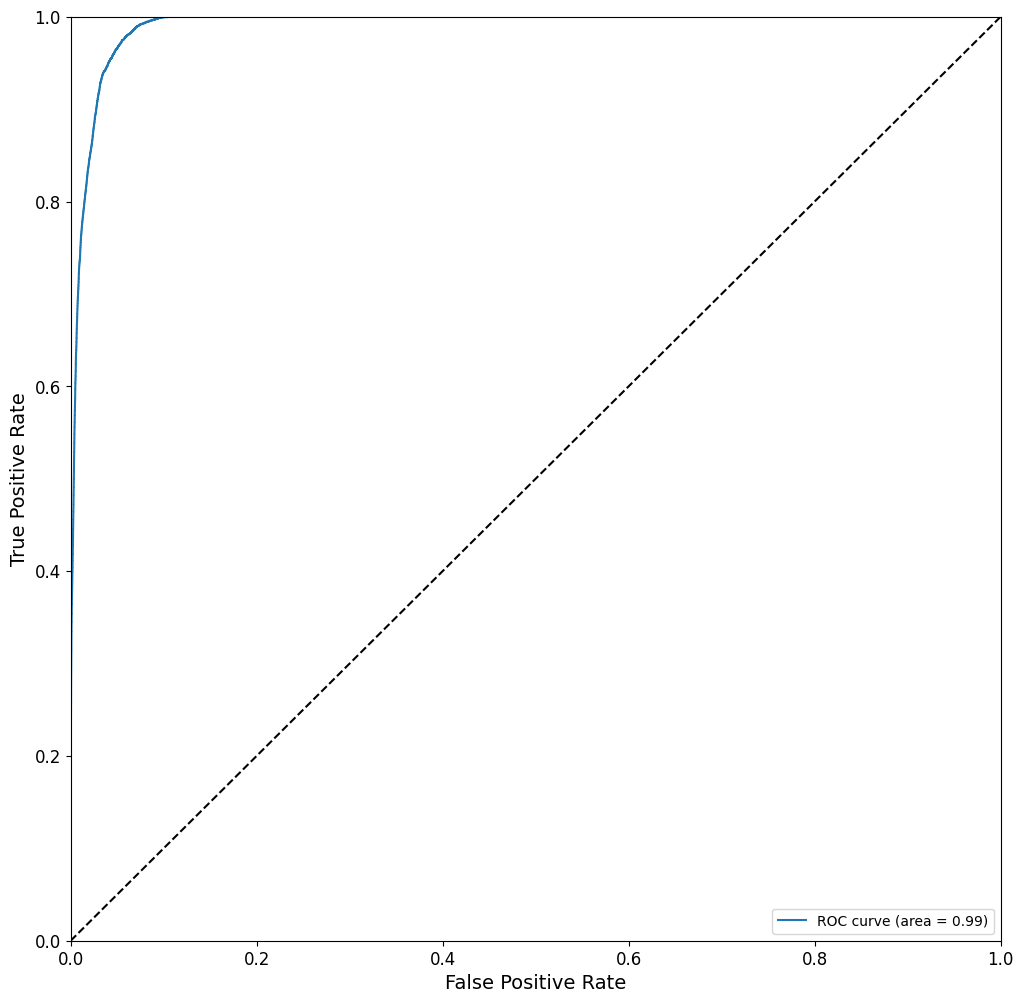

In [96]:
plt.figure(figsize = (12,12))
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
fpr, tpr, _ = metrics.roc_curve(y_test_class, class_models[model_name]['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models[model_name]['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

## Interpretability of Intrinsically interpretable (White-box) models

### Generalized Linear Models (GLMs)

GLMs are a family of methods, starting from the simpler linear regression, and generalising it having the outcome to be a wighted additive sum of processed inputs, however in generalised versions the processed inputs are not just the original atributes, i.e. in the generalised form the outcome is not the linear combination of the original attributes. 

#### Linear Regression

For the interpretation, please refer also to the lecture slides.

In [97]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.55240309e-03 -5.24749967e-03  8.94053311e-01 -1.52969177e-02
 -4.69750145e-01  1.25897658e-01 -6.55039666e-04 -1.17810640e-02
  4.49179892e+01  5.76250776e-04 -3.68909792e-04  3.60777263e-04
  3.73468028e-01 -9.06357562e-01 -6.73995520e-01 -9.17791228e-01
 -9.29847355e-01 -1.03673587e+00 -3.98716237e-01]
intercept:	-38.117693302362404


In [98]:
print('ŷ = %0.2f + %0.4fX₁ + %0.4fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = -38.12 + 0.0046X₁ + -0.0052X₂ + 0.894X₃ + ...


In [99]:
coef_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef': coefs_lm})
print(coef_df)

                feature       coef
0          CRS_DEP_TIME   0.004552
1              DEP_TIME  -0.005247
2             DEP_DELAY   0.894053
3              DEP_AFPH  -0.015297
4              DEP_RFPH  -0.469750
5              TAXI_OUT   0.125898
6            WHEELS_OFF  -0.000655
7      CRS_ELAPSED_TIME  -0.011781
8      PCT_ELAPSED_TIME  44.917989
9              DISTANCE   0.000576
10         CRS_ARR_TIME  -0.000369
11             ARR_AFPH   0.000361
12             ARR_RFPH   0.373468
13        WEATHER_DELAY  -0.906358
14            NAS_DELAY  -0.673996
15       SECURITY_DELAY  -0.917791
16  LATE_AIRCRAFT_DELAY  -0.929847
17           ORIGIN_HUB  -1.036736
18             DEST_HUB  -0.398716


A few comments on the interpretation of the above numbers. 

For continuous attributes, such as ARR_RFPH, for one-unit increase (relative flights per hour), it increases the predicted delay by 0.373844 minutes, if all other features stay the same.

For binary attributes sch as ORIGIN_HUB, the difference between the origin airport being a hub or not is expressed by the coefficient -1.029088. In other words, since it's a negative number, the origin airport is a hub and reduces the delay by just over 1 minute if all other features stay the same.

Categorical: The are no strictly categorical attributes, but we have coded categories as numbers, creating "apparently" ordinal attributes. For exammple, DEP_MONTH and DEP_DOW are integers from 1-12 and 0-6, respectively. We could have instead treated them as dummy or one-hot encoded extra attributes. So a new attribute DEP_FRIDAY and another mew called DEP_JULY could be introduced and attain values 1, if they are true, and 0 if they are not. When we see categorical features, think about whether they can best be treated with dummy variables, or as ordinal ones. 

Base on the above you could calculate the t statistic, to understand individual attribute importance. This is done next by looking at information from the linear model. 

In [100]:
linreg_mdl = sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl = linreg_mdl.fit()
linreg_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 4.697e+05
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:04:00   Log-Likelihood:            -2.6575e+06
No. Observations:              764597   AIC:                         5.315e+06
Df Residuals:                  764577   BIC:                         5.315e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -38.1177      0.124   -307.504      0.000     -38.361     -37.875
CRS_DEP_TIME            0.0046   7.24e-05     62.897      0.000       0.004       0.005
DEP_TIME               -0.0052   9.19e-05    -57.072      0.000      -0.005      -0.005
DEP_DELAY               0.8941      0.000   2950.710      0.000       0.893       0.895
DEP_AFPH               -0.0153      0.000    -47.768      0.000      -0.016      -0.015
DEP_RFPH               -0.4698      0.017    -27.356      0.000      -0.503      -0.436
TAXI_OUT                0.1259      0.001    104.681      0.000       0.124       0.128
WHEELS_OFF             -0.0007   6.71e-05     -9.769      0.000      -0.001      -0.001
CRS_ELAPSED_TIME       -0.0118      0.001    -17.919      0.000      -0.013      -0.010
PCT_ELAPSED_TIME       44.9180      0.117    383.784      0.000      44.689      45.147
DISTANCE                0.0006      8e-05      7.205      0.000       0.000       0.001
CRS_ARR_TIME           -0.0004   2.18e-05    -16.891      0.000      -0.000      -0.000
ARR_AFPH                0.0004      0.000      1.089      0.276      -0.000       0.001
ARR_RFPH                0.3735      0.013     28.351      0.000       0.348       0.399
WEATHER_DELAY          -0.9064      0.001   -995.232      0.000      -0.908      -0.905
NAS_DELAY              -0.6740      0.001   -828.947      0.000      -0.676      -0.672
SECURITY_DELAY         -0.9178      0.005   -167.906      0.000      -0.929      -0.907
LATE_AIRCRAFT_DELAY    -0.9298      0.001  -1826.788      0.000      -0.931      -0.929
ORIGIN_HUB             -1.0367      0.027    -38.876      0.000      -1.089      -0.984
DEST_HUB               -0.3987      0.026    -15.184      0.000      -0.450      -0.347
==============================================================================
Omnibus:                   211179.261   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24385021.880
Skew:                           0.098   Prob(JB):                         0.00
Kurtosis:                      30.666   Cond. No.                     5.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

If you were to hypothesize that the b coefficient to compute the t statistic is 0, in other words, that the attribute has no impact on the model, the distance of the t-statistic from 0 helps reject that null hypothesis. This is what the p-value to the right of the t-statistic does. It's no coincidence that the closest t to 0 (for ARR_AFPH) has the only p-value above 0.05. This puts this atribute at a level of insignificance since everything below 0.05 is statistically significant according to this method of hypothesis testing. So to rank our features, let's extract the data frame from the statsmodels summary. Then, we drop the const (the intercept) because this is not a feature. We need the names of the features to make sense of it, so we turn this array of features into its dataframe. Then, we concatenate the names dataframe with the summary dataframe. Finally, we make a new column with the absolute value of the t-statistic and sort it accordingly. To demonstrate how the absolute value of the t-statistic and p-value are inversely related, we are also color-coding these columns:

In [101]:
summary_df = linreg_mdl.summary2().tables[1]
summary_df = summary_df.drop(['const']).reset_index().rename(columns={'index':'feature'})
summary_df['t_abs'] = abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|']).\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['t_abs'])

,feature,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
2,DEP_DELAY,0.894053,0.000303,2950.710347,0.000000,0.893459,0.894647,2950.710347
16,LATE_AIRCRAFT_DELAY,-0.929847,0.000509,-1826.788434,0.000000,-0.930845,-0.928850,1826.788434
13,WEATHER_DELAY,-0.906358,0.000911,-995.231567,0.000000,-0.908143,-0.904573,995.231567
14,NAS_DELAY,-0.673996,0.000813,-828.947333,0.000000,-0.675589,-0.672402,828.947333
8,PCT_ELAPSED_TIME,44.917989,0.117040,383.784445,0.000000,44.688595,45.147383,383.784445
15,SECURITY_DELAY,-0.917791,0.005466,-167.905544,0.000000,-0.928505,-0.907078,167.905544
5,TAXI_OUT,0.125898,0.001203,104.681267,0.000000,0.123540,0.128255,104.681267
0,CRS_DEP_TIME,0.004552,0.000072,62.897299,0.000000,0.004411,0.004694,62.897299
1,DEP_TIME,-0.005247,0.000092,-57.072449,0.000000,-0.005428,-0.005067,57.072449
3,DEP_AFPH,-0.015297,0.000320,-47.767793,0.000000,-0.015925,-0.014669,47.767793


Linear regression: Interesting! Different types of delays are in top six positions (5 out of 6). Remember that linear regresssion can be confused when there are co-linearities among the attributes.  further later.

#### Ridge Regression

In [102]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef_linear': coefs_lm,\
                        'coef_ridge': coefs_ridge})
coef_ridge_df.style.\
    background_gradient(cmap='viridis_r', low=0.3, high=0.2, axis=1)

,feature,coef_linear,coef_ridge
0,CRS_DEP_TIME,0.004552,-0.022850
1,DEP_TIME,-0.005247,-0.032027
2,DEP_DELAY,0.894053,0.904146
3,DEP_AFPH,-0.015297,-0.015753
4,DEP_RFPH,-0.469750,-0.469728
5,TAXI_OUT,0.125898,0.125962
6,WHEELS_OFF,-0.000655,-0.026955
7,CRS_ELAPSED_TIME,-0.011781,-0.011563
8,PCT_ELAPSED_TIME,44.917989,44.917980
9,DISTANCE,0.000576,0.003023


Ridge regression penalised complexity to enhance generalisation. There is a technique to adapt ridge regression to classification problems. It converts the labels to a -1 to 1 scale for training to predict values between  andthen turns them back to a 0-1 scale. It uses regularized linear regression to fit the data, and can be interpreted in the same way. Now when yo usee the coeff_ridge and compare it with coef_linear for each attribute, you will observe very high similarities (although they are not identical). These coefficients can be interpreted to some extent as in the case of linear regression. But we can also run an iterative experiment to figure out empirically which parameter was the best. So we iterate through 100 possible alpha values, fitting the data to the ridge model which each alpha, and then appending the coefficients to an array. We exclude one coefficient in the array simply because it's so much larger than the rest and it will make it harder to visualize the effects of shrinkage:

In [103]:
num_alphas = 100
alphas = np.logspace(0, 13, num_alphas)
alphas_coefs = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
    alphas_coefs.append(np.concatenate((ridge.coef_[:8],ridge.coef_[9:])))

And next we plot the progression of coefficients

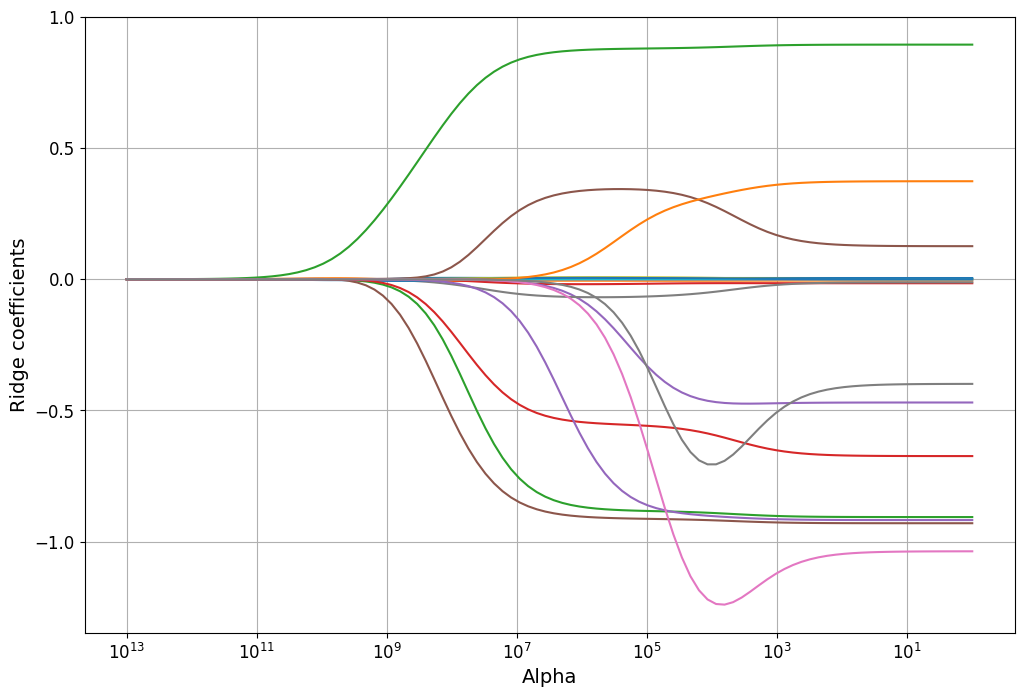

In [104]:
plt.figure(figsize = (12,8))
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Ridge coefficients', fontsize = 14)
plt.grid()
plt.show()

In the above graph, the higher the alpha, the higher the regularization. When alpha is 1012, all coefficients have converged to 0, and as the alpha becomes smaller, they get to a point where they have all diverged and more or less stabilized. In this case, this point is reached at about 102. Another way of seeing it is when all coefficients are around 0, it means that the regularization is so strong that all features are irrelevant. When they have sufficiently diverged and stabilized, the regularization makes them all relevant, which defeats the purpose. Now on that note, if we go back to our code, we will find that this is what we chose for alphas in our RidgeCV: alphas=[1e-3, 1e-2, 1e-1, 1]. As you can tell from the preceding plot, by the time the alphas have reached  and below, the coefficients have already stabilized even though they are still fluctuating slightly. This can explain why our ridge was not better performing than linear regression. Usually, you would expect a regularized model to perform better than one that isn't – unless your hyperparameters are not right. This in an indication that more experiments with different alpha values would be needed. 

So we cannot draw any further conclusions apart from feature importance, in a similar way to the linerar regression. However, overall meaninful interpretability is not particularly evident. 

### Decision Trees

#### CART Decision Trees

Decision Trees are among the most explainable methods. By observing the tree below you could easily see the rules (just observe the top line in each tree node). However, they tend to overfit the data, so the validity of the formed rules is not guaranteed. Visualisation becomes harder though for larger trees. 

C:\Users\chris\AppData\Local\Temp\ipykernel_22120\232009503.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


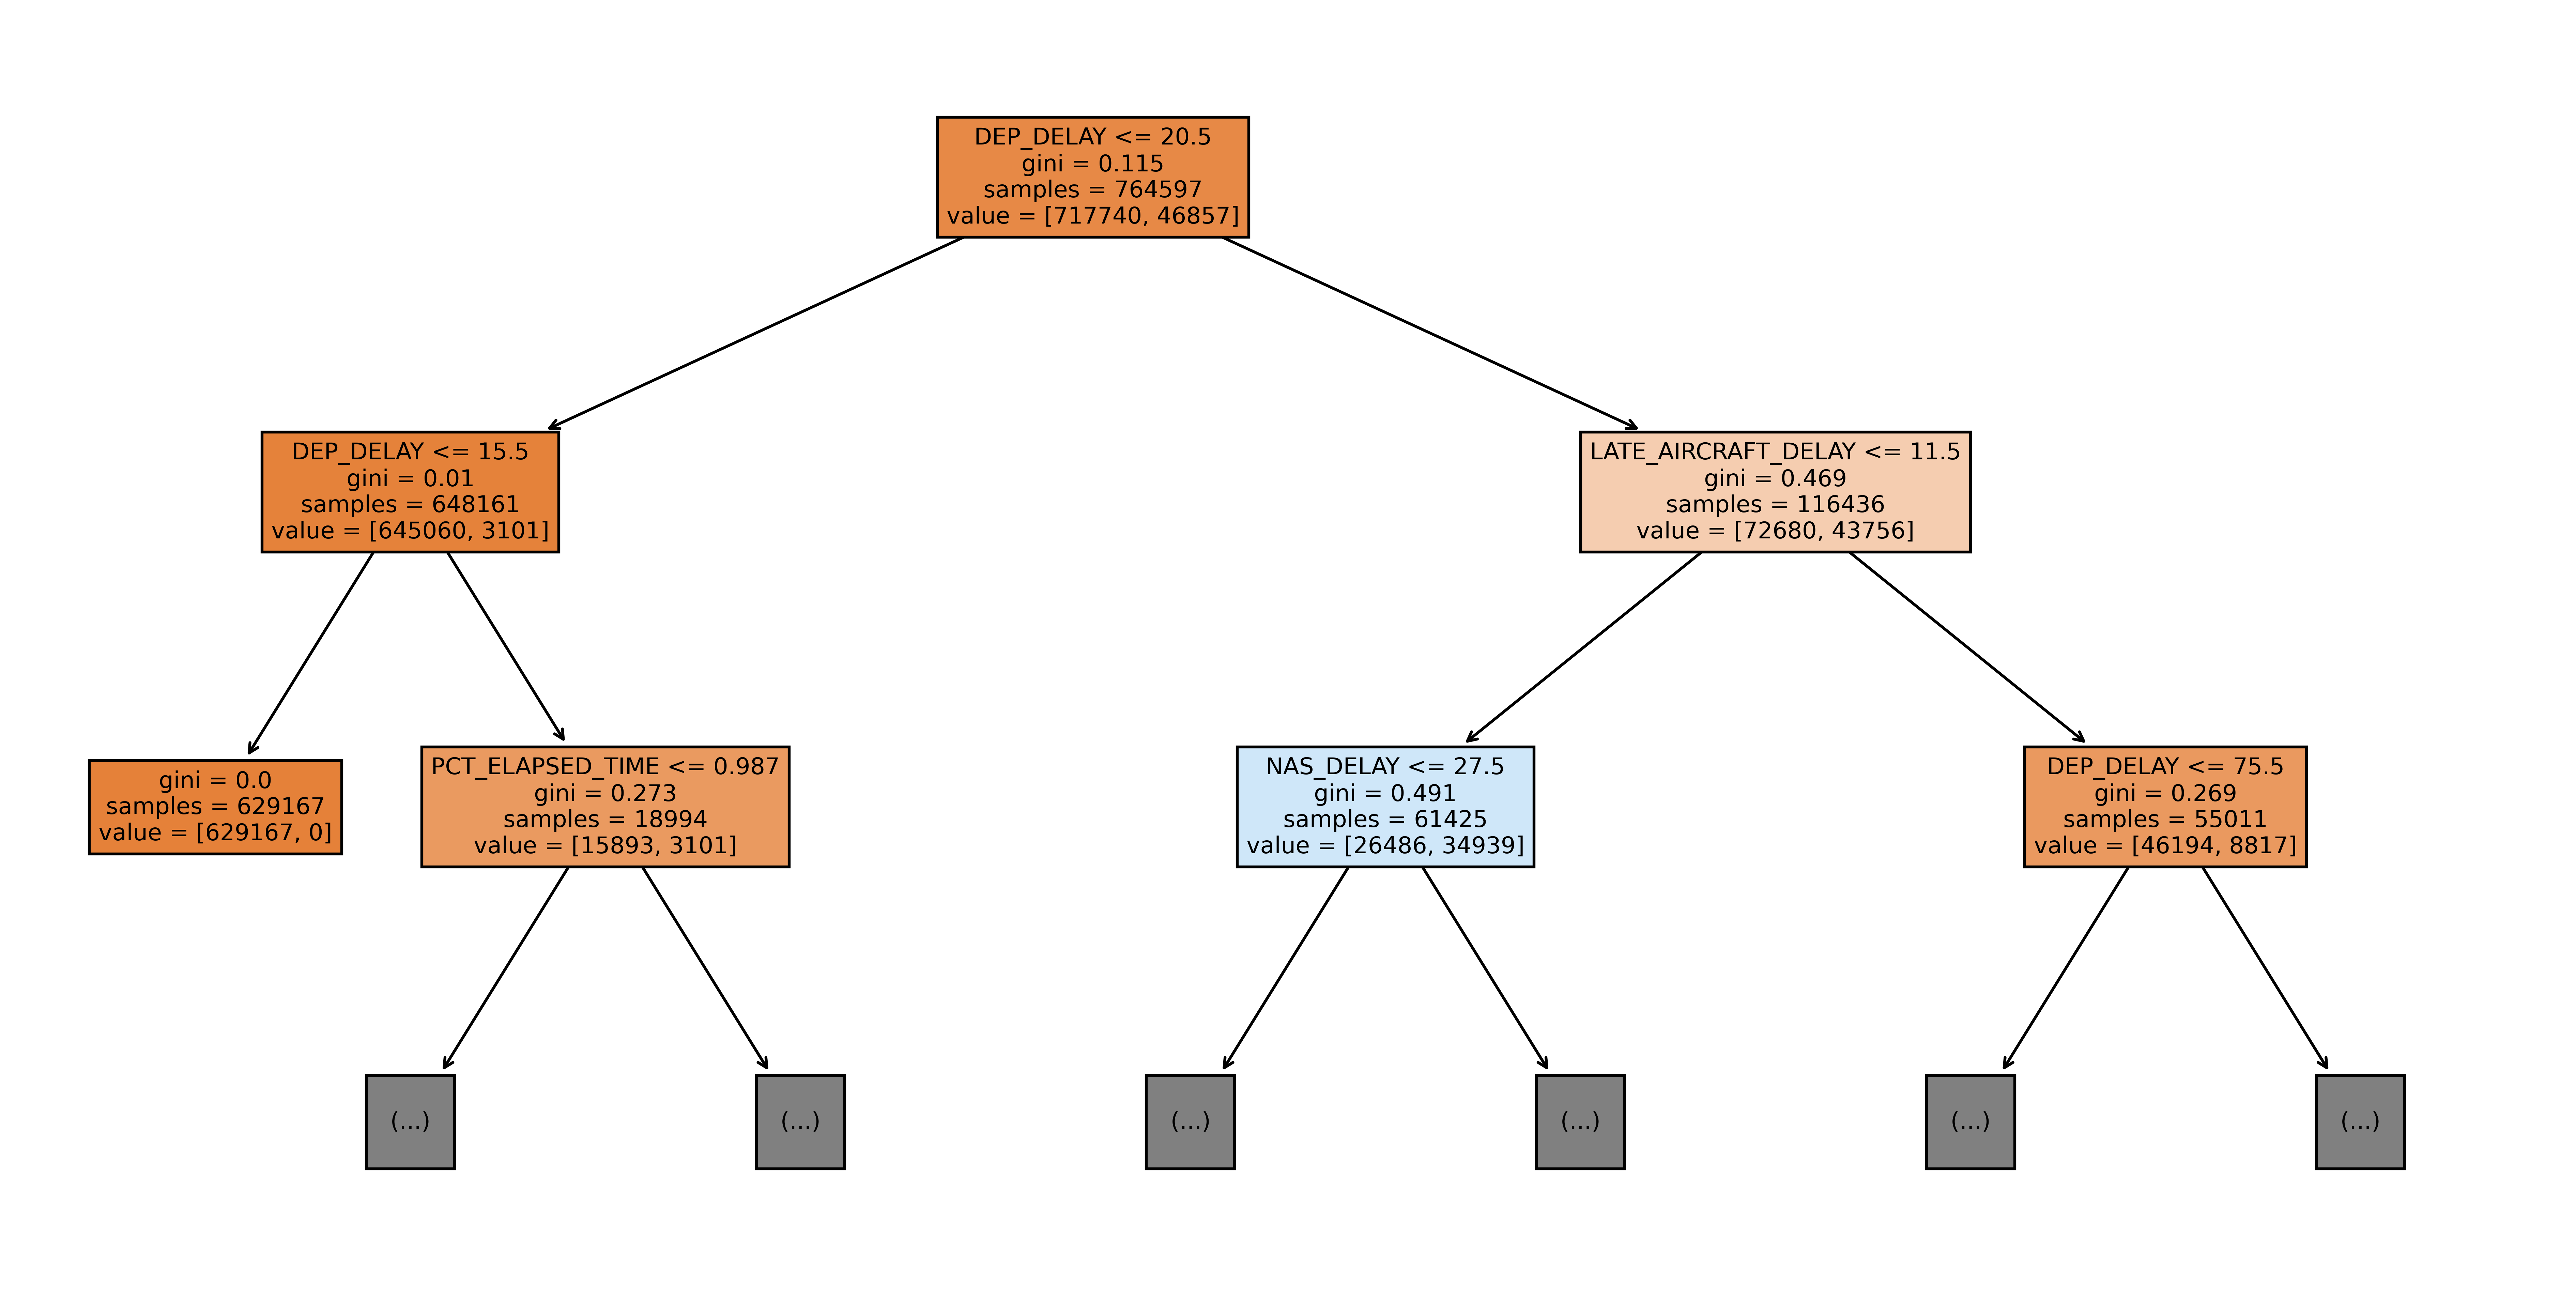

In [110]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [111]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

Calculating feature importance in a CART decision tree is reasonably straightforward. As you can appreciate from the visualizations, some features appear more often in the decisions, but their appearances are weighted by how much they contributed to the overall reduction in the Gini index compared to the previous node. All the sum of the relative decrease in the Gini index throughout the tree is tallied, and the contribution of each feature is a percentage of this reduction:

In [113]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'importance': class_models['decision_tree']['fitted'].feature_importances_}).\
            sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
2,DEP_DELAY,0.527482
16,LATE_AIRCRAFT_DELAY,0.199153
8,PCT_ELAPSED_TIME,0.105381
13,WEATHER_DELAY,0.101649
14,NAS_DELAY,0.062732
15,SECURITY_DELAY,0.001998
9,DISTANCE,0.001019
7,CRS_ELAPSED_TIME,0.000281
5,TAXI_OUT,0.000239
6,WHEELS_OFF,0.000035


Again 5 of the top 6 features are other delays. Attributes may be conveying the same information actually. However, the good thing with Decision trees is that they can be contrasted against domain expertise. So a discussion within team can be initiated. 